In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [2]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [11]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [36]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)



(7, 7) (1, 7)
(7, 7) (1, 7)
Alphas for hard margins:  [[ 8.38990363e-14]
 [ 4.02784669e-13]
 [ 4.82356633e-13]
 [-1.04384070e-13]
 [ 6.79860448e-14]
 [-5.76178689e-14]
 [ 3.59864482e-13]
 [ 5.62287071e-14]
 [ 2.59667114e-13]
 [ 1.19472068e-12]
 [ 7.33670928e-13]
 [ 2.63722666e-13]
 [ 7.68605351e-13]
 [ 1.00213700e-13]
 [ 8.61006086e-13]
 [-1.03723199e-13]
 [ 5.19280606e-13]
 [ 1.27006805e+02]
 [ 1.86410544e-13]
 [ 8.21373990e+01]
 [ 2.22171868e-13]
 [ 1.69874550e+02]
 [ 1.36500268e-13]
 [ 3.20844216e-13]
 [ 8.95259794e-14]
 [ 1.05864911e-13]
 [ 8.38503973e-14]
 [ 5.24535859e-13]
 [ 7.53948814e-13]
 [ 1.21440781e-13]
 [ 6.87878534e-14]
 [ 1.53941521e+01]
 [ 4.84438139e-14]
 [ 9.21779540e-14]
 [ 1.94070759e-13]
 [ 7.03481175e-14]
 [ 1.07065356e-14]
 [ 2.14951408e-14]
 [-9.59840052e-15]
 [ 8.54612135e-15]
 [-6.69862268e-14]
 [ 2.30630963e-13]
 [ 4.38626143e-12]
 [ 1.84581409e-13]
 [ 5.94257505e-13]
 [ 1.26092649e-13]
 [ 5.82877842e-14]
 [ 3.98331985e-13]
 [ 1.29389722e-13]
 [ 4.57962201e-

In [37]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[5.73631885e-11]
 [8.09231195e-11]
 [1.71879105e-10]
 [4.35944838e-11]
 [2.83384151e-11]
 [3.70749032e-11]
 [3.56234987e-11]
 [3.61749772e-11]
 [3.51610260e-11]
 [1.74337464e-10]
 [4.58056989e-11]
 [7.13863479e-11]
 [9.89100446e-11]
 [3.90360964e-11]
 [1.53281809e-10]
 [3.29068618e-11]
 [1.53605604e-10]
 [1.27006805e+02]
 [5.06943607e-11]
 [8.21373990e+01]
 [8.80617094e-11]
 [1.69874550e+02]
 [7.94187097e-11]
 [1.62803819e-10]
 [3.78935668e-11]
 [2.96148487e-11]
 [6.65743609e-11]
 [4.14153864e-11]
 [1.91762513e-10]
 [5.98593929e-11]
 [3.27960076e-11]
 [1.53941521e+01]
 [3.03621627e-11]
 [5.15577259e-11]
 [9.47192649e-11]
 [2.93417915e-11]
 [2.70116375e-11]
 [6.95927541e-11]
 [3.59560436e-11]
 [4.26443609e-11]
 [8.12070709e-11]
 [6.41051127e-11]
 [1.17098693e-09]
 [7.05222074e-11]
 [1.40248446e-10]
 [5.81130006e-11]
 [3.09714955e-11]
 [1.04980891e-10]
 [9.87246440e-11]
 [1.28847478e-10]
 [5.27616479e-11]
 [2.82081254e-11]
 [6.26615147e-11]
 [8.15416818e-11]
 [

<a list of 3 text.Text objects>

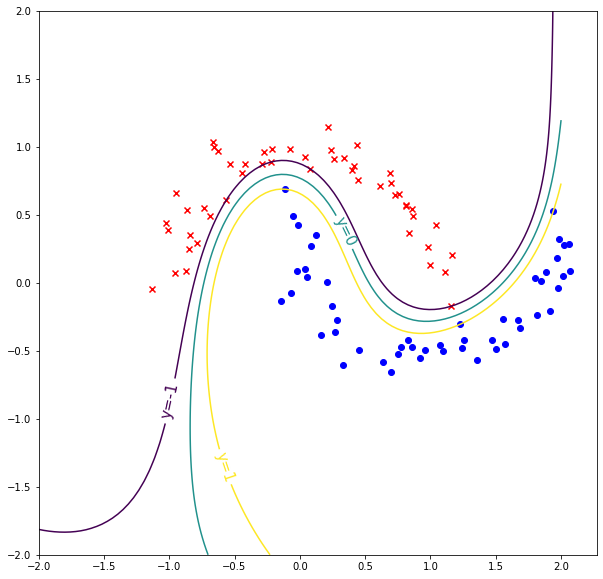

In [38]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)


<a list of 3 text.Text objects>

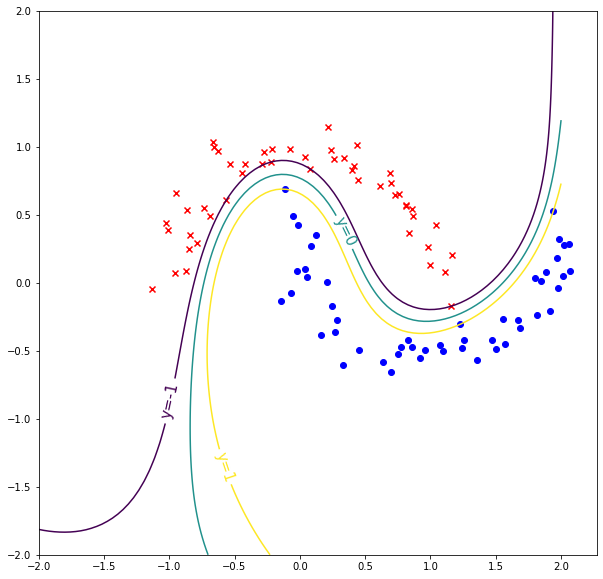

In [40]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)